<a href="https://colab.research.google.com/github/Mikeygoldman1/Group12_MBTI/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of MBTI Personality Using a Hybrid CNN+LSTM DL Model

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import string
import nltk
from random import sample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import warnings
from collections import Counter


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/mbti_1.csv")

## Preprocessing 

In [ ]:
import re
import nltk
!pip install contractions
import contractions
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
def preprocess_1(text):
    # Lowering letters
    text = text.lower()

    # Removing emails & twitter usernames
    text = re.sub('\S*@\S*', '', text)

    # Expand contractions   
    text=contractions.fix(text)
        
    # Removing urls (S+ matches all non whitespace chars)
    text = re.sub(r'http\S*', '', text)
        
    # Removing numbers
    text = re.sub('[^a-zA-Z]',' ',text)

    # # Remove MBTI type mentions from posts 
    # text = re.sub(r"(intj)|(intp)|(infp)|(infj)|(istj)|(istp)|(isfp)|(isfj)|(entj)|(entp)|(enfp)|(enfj)|(estj)|(estp)|(esfp)|(esfj')", ' ', text)

    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def preprocess_2(text):
    # Removing all whitespaces in order to join with proper whitespace
    word_tokens = word_tokenize(text)
     

    # Removing all stop words
    english_stopwords = stopwords.words('english')  
    word_tokens = [word for word in word_tokens if not word in english_stopwords] 
    
    
    # Lemmatize the text 
    lemmatizer = WordNetLemmatizer()
    word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens ]

    return ' '.join(word_tokens)
    

In [ ]:
dataset['posts'] = dataset['posts'].apply(preprocess_1)
dataset['posts'] = dataset['posts'].apply(preprocess_2)

## Splitting Data into Train and Test sets for each Dichotomy 

In [ ]:
from sklearn.model_selection import train_test_split
Train_X,Test_X,Train_Y,Test_Y=model_selection.train_test_split(dataset['posts'],dataset['type'],random_state=42,test_size=0.1)


In [ ]:
IE_Train_Y=Train_Y.apply(lambda x: 1 if x[0]=='I' else 0)
NS_Train_Y=Train_Y.apply(lambda x: 1 if x[1]=='N' else 0)
TF_Train_Y=Train_Y.apply(lambda x: 1 if x[2]=='T' else 0)
JP_Train_Y=Train_Y.apply(lambda x: 1 if x[3]=='J' else 0)

IE_Test_Y=Test_Y.apply(lambda x: 1 if x[0]=='I' else 0)
NS_Test_Y=Test_Y.apply(lambda x: 1 if x[1]=='N' else 0)
TF_Test_Y=Test_Y.apply(lambda x: 1 if x[2]=='T' else 0)
JP_Test_Y=Test_Y.apply(lambda x: 1 if x[3]=='J' else 0)


## Tokenizing Text and Padding

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras import layers

In [ ]:
maxlen=1703
def tokenize_sets(xTrain,xTest):

  #tokenizer takes punctuation into consideration
  tokenizer=Tokenizer(num_words=10000,oov_token="<OOV>") 
  #test set must be completely unseen before
  tokenizer.fit_on_texts(xTrain) 
  
  # Change sentences to sequences
  xTrain=tokenizer.texts_to_sequences(xTrain)
  xTest=tokenizer.texts_to_sequences(xTest)
  num_words=tokenizer.word_index

  
  # Pad data so that all sequences have the same length
  xTrain=pad_sequences(xTrain, maxlen=maxlen,padding='post',truncating='post')
  xTest=pad_sequences(xTest,maxlen=maxlen,padding='post',truncating='post')
 
  return xTrain,xTest,num_words

IE_Train_X,IE_Test_X,num_wordsIE=tokenize_sets(Train_X,Test_X)
NS_Train_X,NS_Test_X,num_wordsNS=tokenize_sets(Train_X,Test_X)
TF_Train_X,TF_Test_X,num_wordsTF=tokenize_sets(Train_X,Test_X)
JP_Train_X,JP_Test_X,num_wordsJP=tokenize_sets(Train_X,Test_X)

## Sampling to deal with imbalanced data 

In [ ]:
!pip install imblearn

In [ ]:
# import imblearn
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42)

# # On Train Dataset
# IE_Train_X,IE_Train_Y = rus.fit_resample(IE_Train_X,IE_Train_Y)
# NS_Train_X,NS_Train_Y = rus.fit_resample(NS_Train_X,NS_Train_Y)
# TF_Train_X,TF_Train_Y = rus.fit_resample(TF_Train_X,TF_Train_Y)
# JP_Train_X,JP_Train_Y = rus.fit_resample(JP_Train_X,JP_Train_Y)

# print('Resample IE training dataset shape', Counter(IE_Train_Y ))
# print('Resample NS training dataset shape', Counter(NS_Train_Y ))
# print('Resample TF training dataset shape', Counter(TF_Train_Y ))
# print('Resample JP training dataset shape', Counter(JP_Train_Y ))

# # On Test Dataset
# IE_Test_X,IE_Test_Y = rus.fit_resample(IE_Test_X,IE_Test_Y)
# NS_Test_X,NS_Test_Y = rus.fit_resample(NS_Test_X,NS_Test_Y)
# TF_Test_X,TF_Test_Y = rus.fit_resample(TF_Test_X,TF_Test_Y)
# JP_Test_X,JP_Test_Y = rus.fit_resample(JP_Test_X,JP_Test_Y)


# print('Resample IE test dataset shape', Counter(IE_Test_Y ))
# print('Resample NS test dataset shape', Counter(NS_Test_Y ))
# print('Resample TF test dataset shape', Counter(TF_Test_Y ))
# print('Resample JP test dataset shape', Counter(JP_Test_Y ))



# import imblearn
# from imblearn.over_sampling import SMOTE 

# rus =  SMOTE(random_state=42)

# # On Train Dataset
# IE_Train_X,IE_Train_Y = rus.fit_resample(IE_Train_X,IE_Train_Y)
# NS_Train_X,NS_Train_Y = rus.fit_resample(NS_Train_X,NS_Train_Y)
# TF_Train_X,TF_Train_Y = rus.fit_resample(TF_Train_X,TF_Train_Y)
# JP_Train_X,JP_Train_Y = rus.fit_resample(JP_Train_X,JP_Train_Y)

# # print('Resample IE training dataset shape', Counter(IE_Train_Y ))
# # print('Resample NS training dataset shape', Counter(NS_Train_Y ))
# # print('Resample TF training dataset shape', Counter(TF_Train_Y ))
# # print('Resample JP training dataset shape', Counter(JP_Train_Y ))

# # On Test Dataset
# IE_Test_X,IE_Test_Y = rus.fit_resample(IE_Test_X,IE_Test_Y)
# NS_Test_X,NS_Test_Y = rus.fit_resample(NS_Test_X,NS_Test_Y)
# TF_Test_X,TF_Test_Y = rus.fit_resample(TF_Test_X,TF_Test_Y)
# JP_Test_X,JP_Test_Y = rus.fit_resample(JP_Test_X,JP_Test_Y)


# print('Resample IE test dataset shape', Counter(IE_Test_Y ))
# print('Resample NS test dataset shape', Counter(NS_Test_Y ))
# print('Resample TF test dataset shape', Counter(TF_Test_Y ))
# print('Resample JP test dataset shape', Counter(JP_Test_Y ))


## Building The Hybrid DL Model for I/E Dichotomy 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential ()
model.add (layers.Embedding (10000, 128,input_length=1703))
model.add (layers.Dropout (0.8))
model.add (layers.Conv1D (32, 3, padding ='same' ,activation = "relu"))
model.add (layers.MaxPooling1D (2))
model.add (layers.LSTM (120, return_sequences = True))
model.add (layers.Flatten ())
model.add(layers.Dense (1, activation = "sigmoid"))
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print (model. summary ())
history = model.fit(IE_Train_X,IE_Train_Y, epochs=30,batch_size=32, validation_split=0.111)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1703, 128)         1280000   
                                                                 
 dropout_8 (Dropout)         (None, 1703, 128)         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1703, 32)          12320     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 851, 32)          0         
 1D)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 851, 120)          73440     
                                                                 
 flatten_8 (Flatten)         (None, 102120)            0         
                                                      

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


217/217 [==============================] - 9s 31ms/step - loss: 0.5505 - accuracy: 0.7663 - val_loss: 0.5795 - val_accuracy: 0.7774
Epoch 2/30
217/217 [==============================] - 6s 30ms/step - loss: 0.5438 - accuracy: 0.7664 - val_loss: 0.5870 - val_accuracy: 0.7774
Epoch 3/30
217/217 [==============================] - 6s 29ms/step - loss: 0.5005 - accuracy: 0.7782 - val_loss: 0.7575 - val_accuracy: 0.5040
Epoch 4/30
217/217 [==============================] - 6s 29ms/step - loss: 0.3678 - accuracy: 0.8398 - val_loss: 0.6077 - val_accuracy: 0.6794
Epoch 5/30
217/217 [==============================] - 6s 29ms/step - loss: 0.3258 - accuracy: 0.8621 - val_loss: 0.5092 - val_accuracy: 0.7555
Epoch 6/30
217/217 [==============================] - 6s 29ms/step - loss: 0.2886 - accuracy: 0.8800 - val_loss: 0.6366 - val_accuracy: 0.6413
Epoch 7/30
217/217 [==============================] - 6s 30ms/step - loss: 0.2722 - accuracy: 0.8890 - val_loss: 0.6054 - val_accuracy: 0.6943
Epoch 8/30

## Validation Curves for I/E Dichotomy 

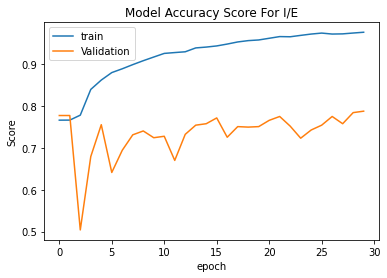

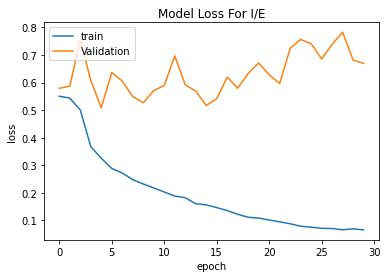

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Score For I/E')
plt.ylabel('Score')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss For I/E')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Evaluating I/E Model on Unseen Test Set 

In [ ]:
evaluation = model.evaluate(IE_Test_X,IE_Test_Y, return_dict=True)


28/28 [==============================] - 0s 12ms/step - loss: 0.6959 - accuracy: 0.7857


28/28 [==============================] - 1s 11ms/step


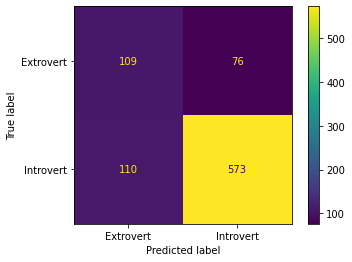

              precision    recall  f1-score   support

           0       0.50      0.59      0.54       185
           1       0.88      0.84      0.86       683

    accuracy                           0.79       868
   macro avg       0.69      0.71      0.70       868
weighted avg       0.80      0.79      0.79       868

0.7140675082109929


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

#Predict
IE_predictions = model.predict(IE_Test_X
)
IE_predictions=tf.math.round(IE_predictions, name=None)
IE_confusion = confusion_matrix(IE_Test_Y, IE_predictions)
IE_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = IE_confusion, display_labels = ['Extrovert', 'Introvert'])
IE_cm_display.plot()
plt.show()
print(classification_report(IE_Test_Y, IE_predictions))

print(balanced_accuracy_score(IE_Test_Y, IE_predictions))

## Building The Hybrid DL Model for N/S Dichotomy 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential ()
model.add (layers.Embedding (10000, 128,input_length=1703))
model.add (layers.Dropout (0.8))
model.add (layers.Conv1D (32, 3, padding ='same' ,activation = "relu"))
model.add (layers.MaxPooling1D (2))
model.add (layers.LSTM (140, return_sequences = True))
model.add (layers.Flatten ())
model.add(layers.Dense (1, activation = "sigmoid"))
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print (model. summary ())
history = model.fit(NS_Train_X,NS_Train_Y, epochs=30,batch_size=32, validation_split=0.111)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1703, 128)         1280000   
                                                                 
 dropout_9 (Dropout)         (None, 1703, 128)         0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1703, 32)          12320     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 851, 32)          0         
 1D)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 851, 140)          96880     
                                                                 
 flatten_9 (Flatten)         (None, 119140)            0         
                                                      

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


217/217 [==============================] - 9s 38ms/step - loss: 0.4055 - accuracy: 0.8599 - val_loss: 0.4972 - val_accuracy: 0.8535
Epoch 2/30
217/217 [==============================] - 8s 37ms/step - loss: 0.3967 - accuracy: 0.8633 - val_loss: 0.4970 - val_accuracy: 0.8535
Epoch 3/30
217/217 [==============================] - 8s 37ms/step - loss: 0.3842 - accuracy: 0.8633 - val_loss: 0.4587 - val_accuracy: 0.8570
Epoch 4/30
217/217 [==============================] - 8s 37ms/step - loss: 0.4951 - accuracy: 0.8566 - val_loss: 0.3692 - val_accuracy: 0.8535
Epoch 5/30
217/217 [==============================] - 8s 37ms/step - loss: 0.2699 - accuracy: 0.8889 - val_loss: 0.3095 - val_accuracy: 0.8870
Epoch 6/30
217/217 [==============================] - 8s 37ms/step - loss: 0.2169 - accuracy: 0.9169 - val_loss: 0.3128 - val_accuracy: 0.8881
Epoch 7/30
217/217 [==============================] - 8s 37ms/step - loss: 0.1883 - accuracy: 0.9269 - val_loss: 0.2881 - val_accuracy: 0.8962
Epoch 8/30

## Validation Curves for N/S Dichotomy 

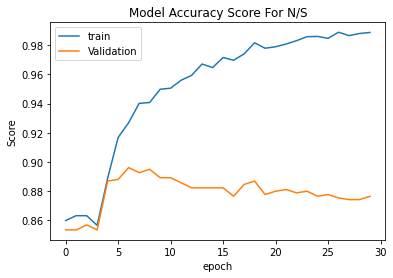

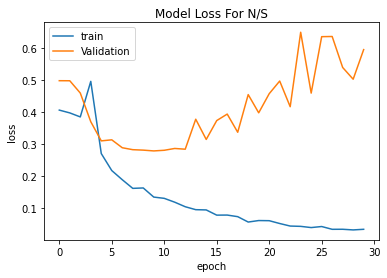

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Score For N/S')
plt.ylabel('Score')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss For N/S')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Evaluating N/S Model on Unseen Test Set 

In [ ]:
evaluation = model.evaluate(NS_Test_X,NS_Test_Y, return_dict=True)


28/28 [==============================] - 0s 14ms/step - loss: 0.5503 - accuracy: 0.8813


28/28 [==============================] - 1s 13ms/step


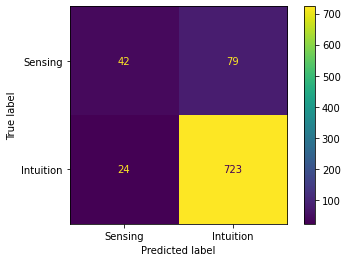

              precision    recall  f1-score   support

           0       0.64      0.35      0.45       121
           1       0.90      0.97      0.93       747

    accuracy                           0.88       868
   macro avg       0.77      0.66      0.69       868
weighted avg       0.86      0.88      0.87       868

0.657489461980152


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

#Predict
NS_predictions = model.predict(NS_Test_X
)
NS_predictions=tf.math.round(NS_predictions, name=None)
NS_confusion = confusion_matrix(NS_Test_Y, NS_predictions)
NS_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = NS_confusion, display_labels = ['Sensing', 'Intuition'])
NS_cm_display.plot()
plt.show()
print(classification_report(NS_Test_Y, NS_predictions))

print(balanced_accuracy_score(NS_Test_Y, NS_predictions))

## Building The Hybrid DL Model for T/F Dichotomy 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential ()
model.add (layers.Embedding (10000, 128,input_length=1703))
model.add (layers.Dropout (0.8))
model.add (layers.Conv1D (32, 3, padding ='same' ,activation = "relu"))
model.add (layers.MaxPooling1D (2))
model.add (layers.LSTM (130, return_sequences = True))
model.add (layers.Flatten ())
model.add(layers.Dense (1, activation = "sigmoid"))
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print (model. summary ())
history = model.fit(TF_Train_X,TF_Train_Y, epochs=30,batch_size=32, validation_split=0.111)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1703, 128)         1280000   
                                                                 
 dropout_10 (Dropout)        (None, 1703, 128)         0         
                                                                 
 conv1d_10 (Conv1D)          (None, 1703, 32)          12320     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 851, 32)          0         
 g1D)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 851, 130)          84760     
                                                                 
 flatten_10 (Flatten)        (None, 110630)            0         
                                                     

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


217/217 [==============================] - 9s 37ms/step - loss: 0.6883 - accuracy: 0.5422 - val_loss: 0.6858 - val_accuracy: 0.5548
Epoch 2/30
217/217 [==============================] - 8s 36ms/step - loss: 0.6587 - accuracy: 0.5921 - val_loss: 0.5579 - val_accuracy: 0.7197
Epoch 3/30
217/217 [==============================] - 8s 36ms/step - loss: 0.4212 - accuracy: 0.8075 - val_loss: 0.4229 - val_accuracy: 0.8131
Epoch 4/30
217/217 [==============================] - 8s 36ms/step - loss: 0.3587 - accuracy: 0.8452 - val_loss: 0.3714 - val_accuracy: 0.8443
Epoch 5/30
217/217 [==============================] - 8s 36ms/step - loss: 0.3271 - accuracy: 0.8635 - val_loss: 0.3746 - val_accuracy: 0.8466
Epoch 6/30
217/217 [==============================] - 8s 36ms/step - loss: 0.3027 - accuracy: 0.8774 - val_loss: 0.3681 - val_accuracy: 0.8454
Epoch 7/30
217/217 [==============================] - 8s 36ms/step - loss: 0.2885 - accuracy: 0.8821 - val_loss: 0.3468 - val_accuracy: 0.8478
Epoch 8/30

## Validation Curves for T/F Dichotomy 

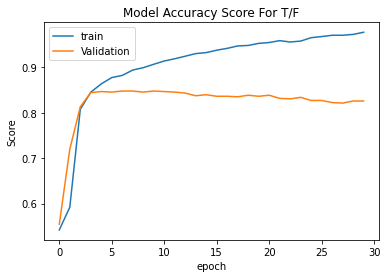

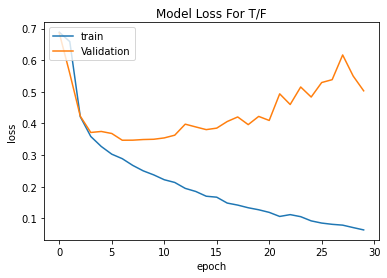

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Score For T/F')
plt.ylabel('Score')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss For T/F')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Evaluating T/F Model on Unseen Test Set 

In [ ]:
evaluation = model.evaluate(TF_Test_X,TF_Test_Y, return_dict=True)


28/28 [==============================] - 0s 13ms/step - loss: 0.6352 - accuracy: 0.8076


28/28 [==============================] - 1s 13ms/step


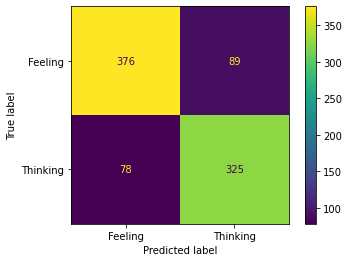

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       465
           1       0.79      0.81      0.80       403

    accuracy                           0.81       868
   macro avg       0.81      0.81      0.81       868
weighted avg       0.81      0.81      0.81       868

0.8075268817204301


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

#Predict
TF_predictions = model.predict(TF_Test_X
)
TF_predictions=tf.math.round(TF_predictions, name=None)
TF_confusion = confusion_matrix(TF_Test_Y, TF_predictions)
TF_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = TF_confusion, display_labels = ['Feeling', 'Thinking'])
TF_cm_display.plot()
plt.show()
print(classification_report(TF_Test_Y, TF_predictions))

print(balanced_accuracy_score(TF_Test_Y, TF_predictions))

## Building The Hybrid DL Model for J/P Dichotomy 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential ()
model.add (layers.Embedding (10000, 128,input_length=1703))
model.add (layers.Dropout (0.8))
model.add (layers.Conv1D (32, 3, padding ='same' ,activation = "relu"))
model.add (layers.MaxPooling1D (2))
model.add (layers.LSTM (130, return_sequences = True))
model.add (layers.Flatten ())
model.add(layers.Dense (1, activation = "sigmoid"))
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print (model. summary ())
history = model.fit(JP_Train_X,JP_Train_Y, epochs=30,batch_size=32, validation_split=0.111)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1703, 128)         1280000   
                                                                 
 dropout_11 (Dropout)        (None, 1703, 128)         0         
                                                                 
 conv1d_11 (Conv1D)          (None, 1703, 32)          12320     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 851, 32)          0         
 g1D)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 851, 130)          84760     
                                                                 
 flatten_11 (Flatten)        (None, 110630)            0         
                                                     

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


217/217 [==============================] - 9s 37ms/step - loss: 0.6742 - accuracy: 0.6017 - val_loss: 0.6798 - val_accuracy: 0.6044
Epoch 2/30
217/217 [==============================] - 8s 35ms/step - loss: 0.6728 - accuracy: 0.6026 - val_loss: 0.6802 - val_accuracy: 0.6044
Epoch 3/30
217/217 [==============================] - 8s 38ms/step - loss: 0.6601 - accuracy: 0.6135 - val_loss: 0.6290 - val_accuracy: 0.6736
Epoch 4/30
217/217 [==============================] - 8s 37ms/step - loss: 0.5183 - accuracy: 0.7480 - val_loss: 0.6504 - val_accuracy: 0.5813
Epoch 5/30
217/217 [==============================] - 8s 36ms/step - loss: 0.4512 - accuracy: 0.7991 - val_loss: 0.6107 - val_accuracy: 0.6563
Epoch 6/30
217/217 [==============================] - 8s 38ms/step - loss: 0.4228 - accuracy: 0.8068 - val_loss: 0.6077 - val_accuracy: 0.6644
Epoch 7/30
217/217 [==============================] - 8s 36ms/step - loss: 0.3881 - accuracy: 0.8336 - val_loss: 0.6486 - val_accuracy: 0.6551
Epoch 8/30

## Validation Curves for J/P Dichotomy 

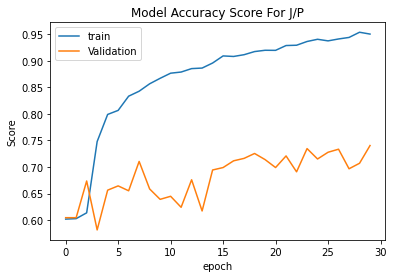

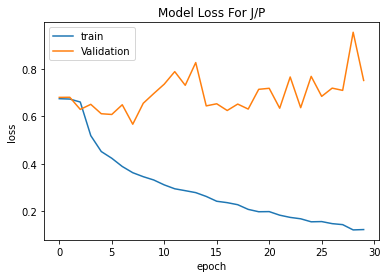

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Score For J/P')
plt.ylabel('Score')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss For J/P')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Evaluating J/P Model on Unseen Test Set 

In [ ]:
evaluation = model.evaluate(JP_Test_X,JP_Test_Y, return_dict=True)


28/28 [==============================] - 0s 13ms/step - loss: 0.6278 - accuracy: 0.7707


28/28 [==============================] - 1s 12ms/step


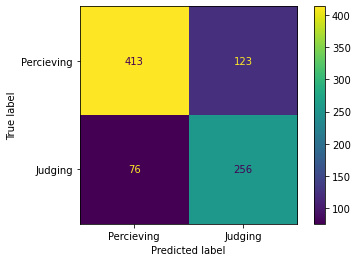

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       536
           1       0.68      0.77      0.72       332

    accuracy                           0.77       868
   macro avg       0.76      0.77      0.76       868
weighted avg       0.78      0.77      0.77       868

0.7708033627045496


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

#Predict
JP_predictions = model.predict(JP_Test_X
)
JP_predictions=tf.math.round(JP_predictions, name=None)
JP_confusion = confusion_matrix(JP_Test_Y, JP_predictions)
JP_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = JP_confusion, display_labels = ['Percieving', 'Judging'])
JP_cm_display.plot()
plt.show()
print(classification_report(JP_Test_Y, JP_predictions))

print(balanced_accuracy_score(JP_Test_Y, JP_predictions))